In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from new_flows.dimension_scaling import ScalingTransform
from nflows.transforms.permutations import RandomPermutation, ReversePermutation

In [2]:
class DatasetMoons:
    """ 
        two half-moons taken from an example 
    """
    def sample(self, n, noise=0.05):
        moons = datasets.make_moons(n_samples=n, noise=noise)[0].astype(np.float32)
        return torch.from_numpy(moons)

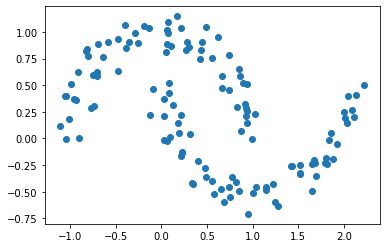

In [3]:
d = DatasetMoons()
x = d.sample(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

In [4]:
num_layers = 10
base_dist = StandardNormal(shape=[2])

transforms = []
for i in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    # if i % 3 == 0:
    transforms.append(ScalingTransform(dim=2, negative=False) )
    #transforms.append(MaskedAffineAutoregressiveTransform(features=2, hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

ipykernel_launcher:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss: 349.99463
ipykernel_launcher:15: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)


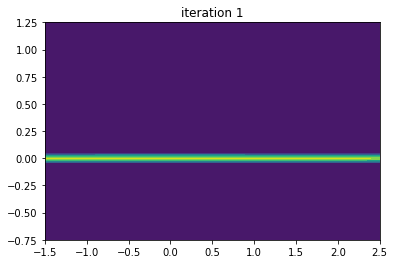

Loss: 83.06197
Loss: 40.02890
Loss: 24.41958
Loss: 16.78906
Loss: 14.99602
Loss: 11.98685
Loss: 10.74613
Loss: 9.60022
Loss: 8.60264
Loss: 8.36245


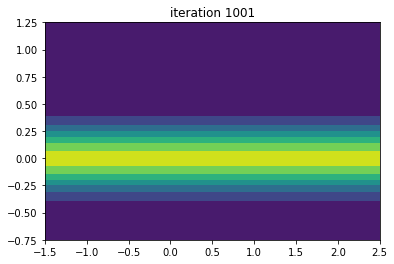

Loss: 7.84066
Loss: 7.64261
Loss: 7.32479
Loss: 7.01556
Loss: 7.05162
Loss: 7.01292
Loss: 6.84015
Loss: 6.80040
Loss: 6.68273
Loss: 6.73711


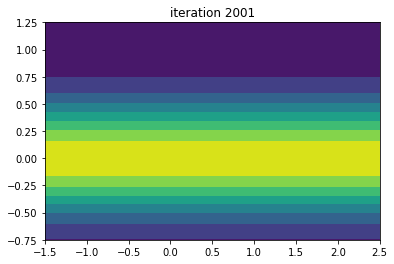

Loss: 6.75676
Loss: 6.79994
Loss: 6.72876
Loss: 6.75274
Loss: 6.73965
Loss: 6.76994
Loss: 6.83369
Loss: 6.81710
Loss: 6.81742
Loss: 6.89232


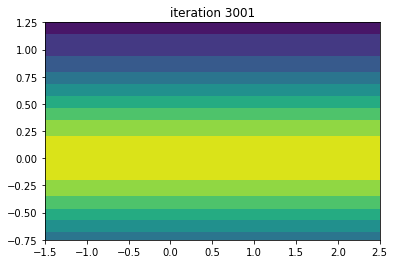

Loss: 6.93870
Loss: 6.95198
Loss: 6.99576
Loss: 7.01751
Loss: 7.10410
Loss: 7.13159
Loss: 7.18179
Loss: 7.22730
Loss: 7.24683
Loss: 7.27963


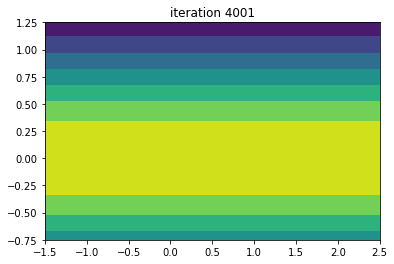

Loss: 7.34949
Loss: 7.38946
Loss: 7.43896
Loss: 7.47858
Loss: 7.53479
Loss: 7.58138
Loss: 7.62200
Loss: 7.67562
Loss: 7.72051
Loss: 7.77111


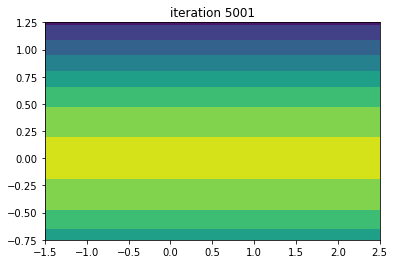

Loss: 7.82476
Loss: 7.87691
Loss: 7.91854
Loss: 7.97205
Loss: 8.01722
Loss: 8.06330
Loss: 8.11636
Loss: 8.16023
Loss: 8.21411
Loss: 8.26322


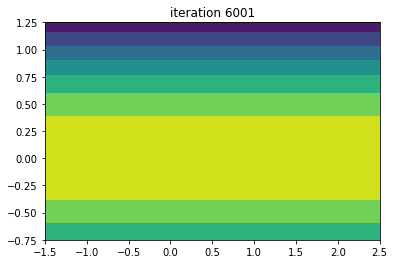

Loss: 8.31222
Loss: 8.36128
Loss: 8.40829
Loss: 8.45776
Loss: 8.50637
Loss: 8.56060
Loss: 8.60916
Loss: 8.65978
Loss: 8.70861
Loss: 8.75929


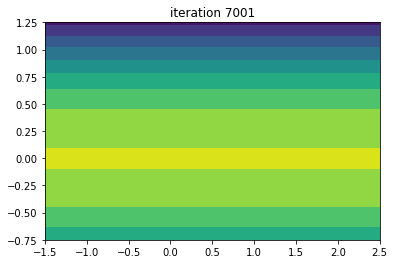

Loss: 8.80826
Loss: 8.85721
Loss: 8.90549
Loss: 8.95777
Loss: 9.00600
Loss: 9.05549
Loss: 9.10617
Loss: 9.15734
Loss: 9.20450
Loss: 9.25680


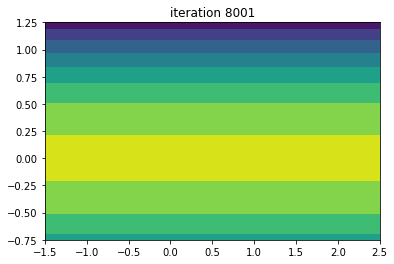

Loss: 9.30607
Loss: 9.35582
Loss: 9.40574
Loss: 9.45536
Loss: 9.50529
Loss: 9.55495
Loss: 9.60641
Loss: 9.65481
Loss: 9.70542
Loss: 9.75562


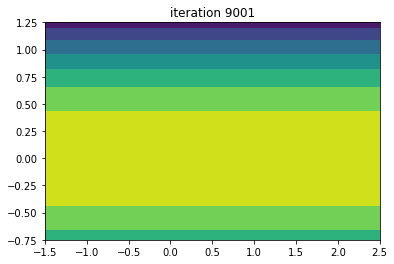

Loss: 9.80413
Loss: 9.85394
Loss: 9.90436
Loss: 9.95433
Loss: 10.00474
Loss: 10.05367
Loss: 10.10488
Loss: 10.15384
Loss: 10.20462


In [5]:
flow.train()
num_iter = 10000
for i in range(num_iter):
    x = d.sample(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()

    if i % 100 == 0: 
        print(f"Loss: {loss :.5f}")
    
    if i % 1000 == 0:
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

In [7]:
flow.eval()
# this is the data 
x = d.sample(256, noise=0.1)
# This is the output from the NF model by taking sampling values x and going to z x->z  
z = flow.sample(128*8)
z2, logabsdet = transform.inverse(z)

print(z[0])
print(z2[0])

x = x.detach().numpy()
z = z.detach().numpy()
z2 = z2.detach().numpy()
# This is sampling from the prior distribution 
p = base_dist.sample(256)

print(z.shape)
print(x.shape)
print(p.shape)


plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.scatter(z2[:,0], z2[:,1], c='r', s=5)
plt.legend(['prior', 'data', 'x->z', "other"])
plt.axis('scaled')
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title('x -> z')

z = flow.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

TypeError: inverse() takes 2 positional arguments but 3 were given